In [1]:
# Convert lora to checkpoint

In [27]:
import torch
from safetensors.torch import load_file, save_file
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
import os
import matplotlib.pyplot as plt

In [26]:
# !/home/ubuntu/anaconda3/envs/dreambooth/bin/pip install matplotlib

In [17]:
LORA_PREFIX_UNET = 'lora_unet'


def convert_name_to_bin(name):
    
    # down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_q.lora_up
    new_name = name.replace(LORA_PREFIX_UNET+'_', '')
    new_name = new_name.replace('.weight', '')
    
    # ['down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_q', 'lora.up']
    parts = new_name.split('.')
    
    #parts[0] = parts[0].replace('_0', '')
    if 'out' in parts[0]:
        parts[0] = "_".join(parts[0].split('_')[:-1])
    parts[1] = parts[1].replace('_', '.')
    
    # ['down', 'blocks', '0', 'attentions', '0', 'transformer', 'blocks', '0', 'attn1', 'to', 'q']
    # ['mid', 'block', 'attentions', '0', 'transformer', 'blocks', '0', 'attn2', 'to', 'out']
    sub_parts = parts[0].split('_')

    # down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q_
    new_sub_parts = ""
    for i in range(len(sub_parts)):
        if sub_parts[i] in ['block', 'blocks', 'attentions'] or sub_parts[i].isnumeric() or 'attn' in sub_parts[i]:
            if 'attn' in sub_parts[i]:
                new_sub_parts += sub_parts[i] + ".processor."
            else:
                new_sub_parts += sub_parts[i] + "."
        else:
            new_sub_parts += sub_parts[i] + "_"
    
    # down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_q_lora.up
    new_sub_parts += parts[1]
    
    new_name =  new_sub_parts + '.weight'
    
    return new_name


def safetensors_to_bin(safetensor_path, bin_path):
    
    bin_state_dict = {}
    safetensors_state_dict = load_file(safetensor_path)
        
    for key_safetensors in safetensors_state_dict:
        # these if are required  by current diffusers' API
        # remove these may have negative effect as not all LoRAs are used
        if 'text' in key_safetensors:
            continue
        if 'unet' not in key_safetensors:
            continue
        if 'transformer_blocks' not in key_safetensors:
            continue
        if 'ff_net' in key_safetensors or 'alpha' in key_safetensors:
            continue
        key_bin = convert_name_to_bin(key_safetensors)
        bin_state_dict[key_bin] = safetensors_state_dict[key_safetensors]
    
    torch.save(bin_state_dict, bin_path)

    
def convert_name_to_safetensors(name):
    
    # ['down_blocks', '0', 'attentions', '0', 'transformer_blocks', '0', 'attn1', 'processor', 'to_q_lora', 'up', 'weight']
    parts = name.split('.')
    
    # ['down_blocks', '_0', 'attentions', '_0', 'transformer_blocks', '_0', 'attn1', 'processor', 'to_q_lora', 'up', 'weight']
    for i in range(len(parts)):
        if parts[i].isdigit():
            parts[i] = '_' + parts[i]
        if "to" in parts[i] and "lora" in parts[i]:
            parts[i] = parts[i].replace('_lora', '.lora')
        
    new_parts = []
    for i in range(len(parts)):
        if i == 0:
            new_parts.append(LORA_PREFIX_UNET + '_' + parts[i])
        elif i == len(parts) - 2:
            new_parts.append(parts[i] + '_to_' + parts[i+1])
            new_parts[-1] = new_parts[-1].replace('_to_weight', '')
        elif i == len(parts) - 1:
            new_parts[-1] += '.' + parts[i]
        elif parts[i] != 'processor':
            new_parts.append(parts[i])
    new_name = '_'.join(new_parts)
    new_name = new_name.replace('__', '_')
    return new_name


def bin_to_safetensors(bin_path, safetensor_path):
    
    bin_state_dict = torch.load(bin_path)
    safetensors_state_dict = {}
    
    for key_bin in bin_state_dict:
        key_safetensors = convert_name_to_safetensors(key_bin)
        safetensors_state_dict[key_safetensors] = bin_state_dict[key_bin]
    
    save_file(safetensors_state_dict, safetensor_path)

In [52]:
model_id = "gsdf/Counterfeit-V2.5"
pipeline = StableDiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float32)

Fetching 12 files: 100%|██████████████████████████████████████████████| 12/12 [00:00<00:00, 89399.02it/s]


In [14]:
safetensor_path = "/home/ubuntu/diffusers/JiaranDianaLoraASOUL_v20SingleCostume.safetensors"

In [15]:
os.path.exists(safetensor_path)

True

In [16]:
bin_path = "/home/ubuntu/diffusers/Jiaran.bin"

In [18]:
safetensors_to_bin(safetensor_path, bin_path)

In [53]:
pipeline.unet.load_attn_procs(bin_path)

In [54]:
pipeline.enable_model_cpu_offload()

100%|████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.37it/s]


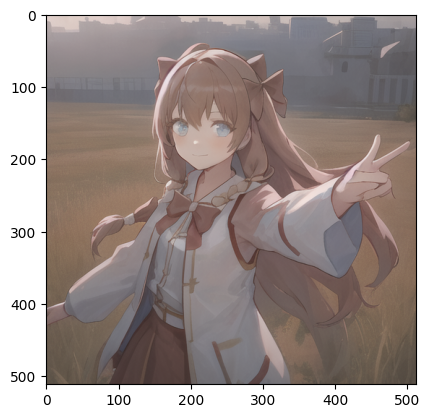

In [65]:
generator = torch.Generator(device="cpu").manual_seed(5)
# prompt = "masterpiece, jiaran, best quality, 1girl, solo, red hair, blue eyes, long hair, red hair bow, light smile, closed mouth"
prompt = "masterpiece, best quality, 1girl, solo, dynamic pose, brown hair, blue eyes, long hair, red hair bow, <lora:JiaranDianaLoraASOUL_v20SingleCostume:1>, light smile, closed mouth, reaching out, floating hair, meadow, reaching towards viewer, selfie,"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output = pipeline(
    prompt,
    negative_prompt = negative_prompt,
    generator=generator,
    num_inference_steps=20,
)
plt.imshow(output[0][0])